In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications import vgg16 as _vgg16
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

import skimage.io

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, DeepFool

import shap
import tensorflow.compat.v1.keras.backend as K

In [2]:
#Load pretrained model 

# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
# model = tf.keras.models.load_model('..\\data\\model')

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions 
model=VGG16()

# from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
# model=VGG19()

# from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions
# model=MobileNet()

# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
# model=InceptionV3()

In [3]:
def tab(img):
    #making prediction
    preds = np.round(model.predict(preprocess_input(np.expand_dims(img.copy(), axis=0))),5)
    predict=[]
    global class_names

    if (model.name=='AkinolaVGG16'):
        class_names={'0':'chimpanzee', '1':'gorilla','2':'white_tiger'}
        preds_data = dict(zip(class_names.values(), preds[0]))
    else:
        decoded_preds=decode_predictions(preds,top=10)
        class_names={}
        ind =(-preds[0]).argsort()[:10]
        for i in range (10):
            class_names[str(ind[i])]=decoded_preds[0][i][1]
            predict.append(decoded_preds[0][i][2])
        preds_data = dict(zip(class_names.values(), predict))

    #plot results
    plt.bar(range(len(preds_data)), list(preds_data.values()), align='center')
    plt.xticks(range(len(preds_data)), list(preds_data.keys()),rotation=45,va='center_baseline',horizontalalignment='right')
    plt.show

In [4]:
img = tf.keras.preprocessing.image.load_img("image5.jpg", target_size=(224, 224))
# img = tf.keras.preprocessing.image.load_img("image4.jpg", target_size=(299, 299)) # inceptionv3
# img = np.array(img)

img = tf.keras.preprocessing.image.img_to_array(img)
img = np.reshape(img,[-1,224,224,3])

In [5]:
X,y = shap.datasets.imagenet50()

In [6]:
# defining shap vals layer method

def shap_vals_layer(n,img):
  # explain how the input to the "n" layer of the model explains the top two classes
  def map2layer(x, layer):
      feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
      return K.get_session().run(model.layers[layer].input, feed_dict)
  e = shap.GradientExplainer(
      (model.layers[n].input, model.layers[-1].output),
      map2layer(X, n),
      local_smoothing=1 # std dev of smoothing noise
  )

  shap_values,indexes = e.shap_values(map2layer(img, n),ranked_outputs=3)
  return (shap_values,indexes)

In [7]:
classifier = KerasClassifier( model=model, clip_values=(0, 255))

In [8]:
attack = DeepFool(classifier,epsilon=20)
attack2 = FastGradientMethod(classifier,eps=5,targeted=True)

In [9]:
img_adv = attack.generate(img,y=[289])
img_adv2 = attack2.generate(img,y=[289])

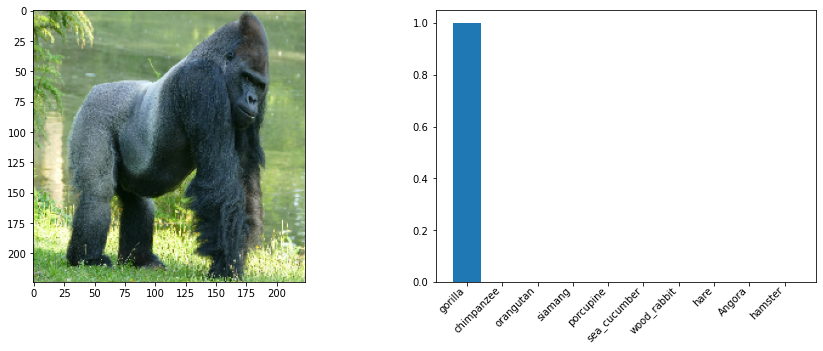

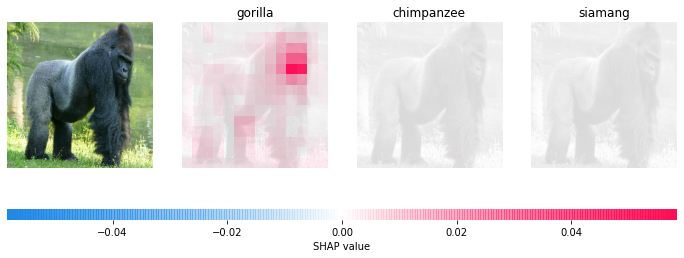

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].imshow(img[0]/255)
axes[1]=tab(img[0])

value,index=shap_vals_layer(15,img)
shap.image_plot(value,img,np.vectorize(lambda x: class_names[str(x)])(index))


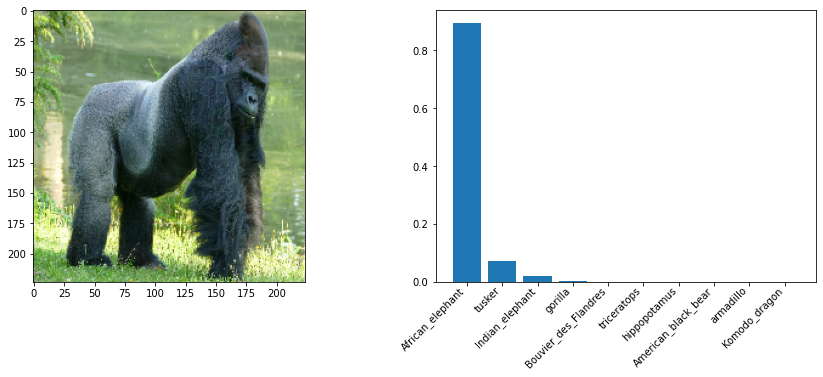

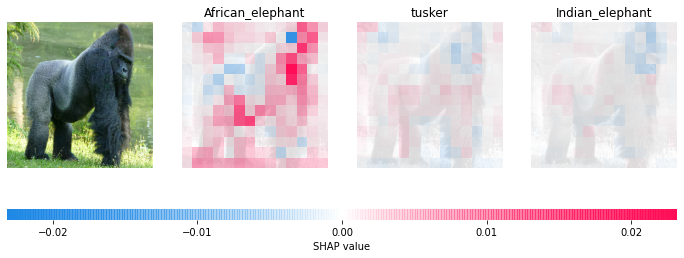

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].imshow(img_adv[0]/255)
axes[1]=tab(img_adv[0])

value,index=shap_vals_layer(15,img_adv)
shap.image_plot(value,img_adv,np.vectorize(lambda x: class_names[str(x)])(index))

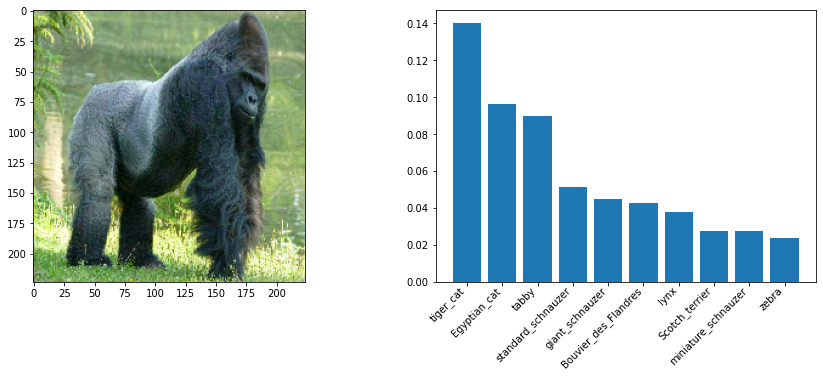

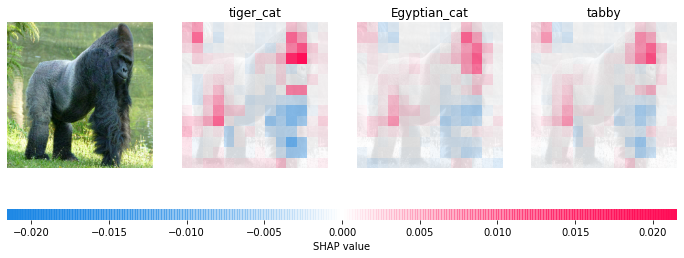

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].imshow(img_adv2[0]/255)
axes[1]=tab(img_adv2[0])

value,index=shap_vals_layer(15,img_adv2)
shap.image_plot(value,img_adv2,np.vectorize(lambda x: class_names[str(x)])(index))